In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, regularizers, initializers, models
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [ ]:
cifar100 = keras.datasets.cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("x_train:", len(x_train), "x_test:", len(x_test))

169017344/169001437 [==============================] - 6s 0us/step
x_train: 50000 x_test: 10000


In [ ]:
#BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3)
def dense_block(input_tensor,
                filters,
                stage,
                block,
                bn_decay=0.9,
                bn_epsilon=1e-5):
  filters1,filters2=filters

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  dense_name='dense'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(input_tensor)

  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters1,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=dense_name+'2a')(x)

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2b')(x)
  
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(filters2,(3,3),padding='same',use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=dense_name+'2b')(x)

  x = layers.concatenate([x,input_tensor])

  return x

In [ ]:
#BN → 1×1 convolutional layer → 2×2 average pooling layer
def transition_block(input_tensor,
                     filters,
                     stage,
                     block,
                     bn_decay=0.9,
                     bn_epsilon=1e-5):
  if backend.image_data_format() == 'channels_last':
    bn_axis=3
  else:
    bn_axis=1

  transition_name = 'transition'+str(stage)+block+'_branch'
  bn_name='bn'+str(stage)+block+'_branch'

  x = layers.BatchNormalization(axis=bn_axis,
                                momentum=bn_decay,
                                epsilon=bn_epsilon,
                                name=bn_name+'2a')(input_tensor)

  x = layers.Conv2D(filters,(1,1),use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name=transition_name+'2a')(x)

  x = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)

  return x

In [ ]:
def DenseNet121(num_classes,
                batch_size=None,
                bn_decay=0.9,
                bn_epsilon=1e-5):
  
  input_shape=(32,32,3)
  input = layers.Input(shape=input_shape,batch_size=batch_size)

  if backend.image_data_format() == 'channels_last':
    bn_axis=3
    x = input
  else:
    x = layers.permute((3,1,2))(input)
    bn_axis=1

  config_block=dict(bn_decay=bn_decay,
                    bn_epsilon=bn_epsilon)
  x = layers.Conv2D(64,(7,7),strides=(2,2),padding='valid',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(1e-4),
                    name='conv1')(x)

  x = layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

  x = dense_block(x,[128,32],stage=2,block='a',**config_block)
  x = dense_block(x,[128,32],stage=2,block='b',**config_block)
  x = dense_block(x,[128,32],stage=2,block='c',**config_block)
  x = dense_block(x,[128,32],stage=2,block='d',**config_block)
  x = dense_block(x,[128,32],stage=2,block='e',**config_block)
  x = dense_block(x,[128,32],stage=2,block='f',**config_block)
  x = transition_block(x,32,stage=2,block='g',**config_block)

  x = dense_block(x,[128,32],stage=3,block='a',**config_block)
  x = dense_block(x,[128,32],stage=3,block='b',**config_block)
  x = dense_block(x,[128,32],stage=3,block='c',**config_block)
  x = dense_block(x,[128,32],stage=3,block='d',**config_block)
  x = dense_block(x,[128,32],stage=3,block='e',**config_block)
  x = dense_block(x,[128,32],stage=3,block='f',**config_block)
  x = dense_block(x,[128,32],stage=3,block='g',**config_block)
  x = dense_block(x,[128,32],stage=3,block='h',**config_block)
  x = dense_block(x,[128,32],stage=3,block='i',**config_block)
  x = dense_block(x,[128,32],stage=3,block='j',**config_block)
  x = dense_block(x,[128,32],stage=3,block='k',**config_block)
  x = dense_block(x,[128,32],stage=3,block='l',**config_block)
  x = transition_block(x,32,stage=3,block='m',**config_block)

  x = dense_block(x,[128,32],stage=4,block='a',**config_block)
  x = dense_block(x,[128,32],stage=4,block='b',**config_block)
  x = dense_block(x,[128,32],stage=4,block='c',**config_block)
  x = dense_block(x,[128,32],stage=4,block='d',**config_block)
  x = dense_block(x,[128,32],stage=4,block='e',**config_block)
  x = dense_block(x,[128,32],stage=4,block='f',**config_block)
  x = dense_block(x,[128,32],stage=4,block='g',**config_block)
  x = dense_block(x,[128,32],stage=4,block='h',**config_block)
  x = dense_block(x,[128,32],stage=4,block='i',**config_block)
  x = dense_block(x,[128,32],stage=4,block='j',**config_block)
  x = dense_block(x,[128,32],stage=4,block='k',**config_block)
  x = dense_block(x,[128,32],stage=4,block='l',**config_block)
  x = dense_block(x,[128,32],stage=4,block='m',**config_block)
  x = dense_block(x,[128,32],stage=4,block='n',**config_block)
  x = dense_block(x,[128,32],stage=4,block='o',**config_block)
  x = dense_block(x,[128,32],stage=4,block='p',**config_block)
  x = dense_block(x,[128,32],stage=4,block='q',**config_block)
  x = dense_block(x,[128,32],stage=4,block='r',**config_block)
  x = dense_block(x,[128,32],stage=4,block='s',**config_block)
  x = dense_block(x,[128,32],stage=4,block='t',**config_block)
  x = dense_block(x,[128,32],stage=4,block='u',**config_block)
  x = dense_block(x,[128,32],stage=4,block='v',**config_block)
  x = dense_block(x,[128,32],stage=4,block='w',**config_block)
  x = dense_block(x,[128,32],stage=4,block='x',**config_block)
  x = transition_block(x,32,stage=4,block='y',**config_block)

  x = dense_block(x,[128,32],stage=5,block='a',**config_block)
  x = dense_block(x,[128,32],stage=5,block='b',**config_block)
  x = dense_block(x,[128,32],stage=5,block='c',**config_block)
  x = dense_block(x,[128,32],stage=5,block='d',**config_block)
  x = dense_block(x,[128,32],stage=5,block='e',**config_block)
  x = dense_block(x,[128,32],stage=5,block='f',**config_block)
  x = dense_block(x,[128,32],stage=5,block='g',**config_block)
  x = dense_block(x,[128,32],stage=5,block='h',**config_block)
  x = dense_block(x,[128,32],stage=5,block='i',**config_block)
  x = dense_block(x,[128,32],stage=5,block='j',**config_block)
  x = dense_block(x,[128,32],stage=5,block='k',**config_block)
  x = dense_block(x,[128,32],stage=5,block='l',**config_block)
  x = dense_block(x,[128,32],stage=5,block='m',**config_block)
  x = dense_block(x,[128,32],stage=5,block='n',**config_block)
  x = dense_block(x,[128,32],stage=5,block='o',**config_block)
  x = dense_block(x,[128,32],stage=5,block='p',**config_block)
  x = transition_block(x,32,stage=5,block='q',**config_block)
  
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      num_classes,
      kernel_initializer='he_normal',
      kernel_regularizer=keras.regularizers.l2(1e-4),
      bias_regularizer=keras.regularizers.l2(1e-4),
      name='1000D_full')(x)
  x = layers.Activation('softmax',dtype='float32')(x)

  return models.Model(input,x,name='DenseNet121')

In [ ]:
densenet121=DenseNet121(num_classes=100)
densenet121.summary()

Model: "DenseNet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 13, 13, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 64)     0           ['conv1[0][0]']                  
                                                                                                  
 bn2a_branch2a (BatchNormalizat  (None, 7, 7, 64)    256         ['max_pooling2d[0][0]']          
 ion)                                                                                   

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.69888 to fit



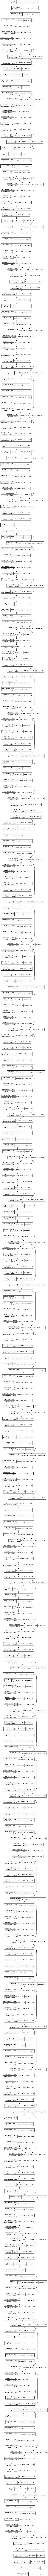

In [ ]:
plot_model(densenet121,show_shapes=True)

In [ ]:
densenet121.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_densenet121 = densenet121.fit(x_train, y_train, epochs=100)

Epoch 1/100
1563/1563 [==============================] - 135s 70ms/step - loss: 6.4161 - accuracy: 0.0474
Epoch 2/100
1563/1563 [==============================] - 109s 70ms/step - loss: 5.9641 - accuracy: 0.0982
Epoch 3/100
1563/1563 [==============================] - 111s 71ms/step - loss: 5.6561 - accuracy: 0.1360
Epoch 4/100
1563/1563 [==============================] - 111s 71ms/step - loss: 5.4268 - accuracy: 0.1679
Epoch 5/100
1563/1563 [==============================] - 107s 69ms/step - loss: 5.2236 - accuracy: 0.1982
Epoch 6/100
1563/1563 [==============================] - 107s 68ms/step - loss: 5.0442 - accuracy: 0.2250
Epoch 7/100
1563/1563 [==============================] - 110s 70ms/step - loss: 4.8758 - accuracy: 0.2546
Epoch 8/100
1563/1563 [==============================] - 112s 71ms/step - loss: 4.7268 - accuracy: 0.2775
Epoch 9/100
1563/1563 [==============================] - 109s 70ms/step - loss: 4.5937 - accuracy: 0.3004
Epoch 10/100
1563/1563 [======================

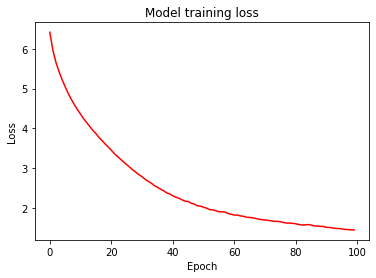

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_densenet121.history['loss'], 'r')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

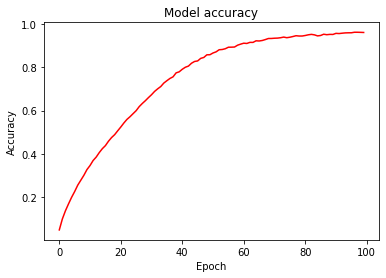

In [ ]:
plt.plot(history_densenet121.history['accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()